# Calculate distortion coefficients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import time

M = np.array([[ -7.36333209e-01,  -1.52041651e+00,   1.10230197e+03],
 [ -8.43769499e-15,  -1.94124210e+00,   8.73558944e+02],
 [ -1.06251813e-17,  -2.39494236e-03,   1.00000000e+00]])


Minv = np.array([[  1.05555556e-01,  -7.83218391e-01,   5.67833333e+02],
 [  4.44089210e-16,  -5.15134100e-01,   4.50000000e+02],
 [ -4.33680869e-19,  -1.23371648e-03,   1.00000000e+00]])


cameraMatrix = np.array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
 [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])


distCoeff = np.array([[ -2.41017956e-01,  -5.30721171e-02,  -1.15810354e-03,  -1.28318858e-04,
    2.67125302e-02]])



# Pipeline definition

In [2]:
def undistort(img, cameraMatrix, distCoeff):
    return cv2.undistort(img, cameraMatrix, distCoeff, None, cameraMatrix)

def threshold(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
            
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
        
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def perspective_transform(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))

def fit_poly_to_lanes(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return(left_fit,right_fit)

def calculate_center_offset():
    pass

def calculate_curvature():
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

def reverse_perspective_transform():
    pass

def lane_overlay(img, Minv,left_fit,right_fit):
    ploty = np.linspace(0, img.shape[0]-1, num=img.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


def pipeline(img, cameraMatrix, distCoeff, M):
    undist = undistort( img, cameraMatrix, distCoeff )
    thresholded = threshold(undist,'x',50,100)
    persp = perspective_transform(thresholded, M)
    (left_fit,right_fit) = fit_poly_to_lanes(persp)
    overlay = lane_overlay(undist, Minv, left_fit, right_fit)    
    return overlay
    

In [3]:
%matplotlib inline
test_images = glob.glob('./test_images/*.jpg')

def show_pipeline(filename):
    img = plt.imread(filename)
    lanes = pipeline(img, cameraMatrix, distCoeff, M)
    plt.imshow(lanes, cmap="gray")    
    
def show_thresh(filename):
    img = plt.imread(filename)
    undist = undistort( img, cameraMatrix, distCoeff )
    thresholded = threshold(undist,'x',10,75)
    persp = perspective_transform(thresholded, M)
    plt.imshow(persp,cmap="gray")

./test_images/test2.jpg


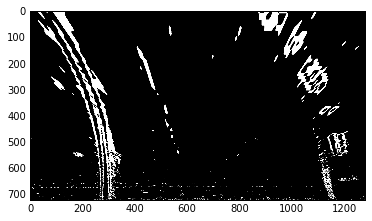

In [ ]:
i = 2
print(test_images[i])
#show_pipeline(test_images[i])
show_thresh(test_images[i])


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def p(img):
    return pipeline(img,cameraMatrix, distCoeff, M)

video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(p) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  5%|▌         | 69/1261 [00:06<02:01,  9.84it/s]

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

